In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# 1. Preprocess the dataset

# Path to your dataset and metadata
metadata_path = r'C:\deepfake videos\metadata.csv'
data_path = r'C:\deepfake videos\FF_Face_only_data'

# Load metadata
metadata = pd.read_csv(metadata_path, header=None)
metadata.columns = ['filename', 'label']

In [2]:
metadata.head()

,filename,label
0,000.mp4,REAL
1,000_003.mp4,FAKE
2,001.mp4,REAL
3,001_870.mp4,FAKE
4,002.mp4,REAL


In [3]:
def extract_frames(video_path, num_frames=32):
    """
    Extracts a fixed number of frames from a video.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()

    if len(frames) == 0:
        # Skip videos with no frames
        print(f"Warning: No frames extracted from {video_path}. Skipping.")
        return None

    if len(frames) >= num_frames:
        frame_indices = np.linspace(0, len(frames) - 1, num_frames).astype(int)
        selected_frames = [frames[i] for i in frame_indices]
    else:
        selected_frames = frames + [frames[-1]] * (num_frames - len(frames))

    return selected_frames


In [4]:
# Create a list of video paths and labels
video_paths = [os.path.join(data_path, filename) for filename in metadata['filename']]
labels = [1 if label == 'FAKE' else 0 for label in metadata['label']]


In [5]:
# Preprocess and split the data
X_train, X_temp, y_train, y_temp = train_test_split(video_paths, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
import torch
from torch.utils.data import Dataset

class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):  
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        frames = extract_frames(video_path)
        if frames is None or len(frames) == 0:
            # Skip this data point if no frames are extracted
            return self.__getitem__((idx + 1) % len(self.video_paths))

        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        frames = torch.stack(frames)

        # Ensure the label is a Long tensor (for CrossEntropyLoss)
        label = torch.tensor(label, dtype=torch.long)  # Use long type for labels

        return frames, label


In [7]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.checkpoint import checkpoint
class DeepFakeDetector(nn.Module):
    def __init__(self):
        super(DeepFakeDetector, self).__init__()
        self.resnext = models.resnext50_32x4d(weights='ResNeXt50_32X4D_Weights.IMAGENET1K_V1')
        self.resnext = nn.Sequential(*list(self.resnext.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(2048, 2048, batch_first=True)
        self.linear = nn.Linear(2048, 1)  # Output 1 for binary classification
        # No softmax here

    def forward(self, x):
        batch_size, num_frames, channels, height, width = x.size()
        x = x.view(batch_size * num_frames, channels, height, width)
        features = checkpoint(self.resnext, x)
        features = self.adaptive_pool(features)
        features = torch.flatten(features, start_dim=1)
        features = features.view(batch_size, num_frames, -1)
        lstm_output, _ = self.lstm(features)
        lstm_output = lstm_output[:, -1, :]
        output = self.linear(lstm_output)
        return output  # Return logits directly


In [8]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112, 112)),  # Reduced size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [9]:
# Create datasets and dataloaders
train_dataset = VideoDataset(X_train, y_train, transform=transform)
val_dataset = VideoDataset(X_val, y_val, transform=transform)
test_dataset = VideoDataset(X_test, y_test, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True,pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False,pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False,pin_memory=True)


In [15]:
# Initialize the model, loss function, and optimizer
import torch.optim as optim
model = DeepFakeDetector()
if torch.cuda.is_available():
    model = model.cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())



In [10]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available! PyTorch is using", torch.cuda.get_device_name(0))
else:
    print("GPU is not available. Using CPU.")

GPU is available! PyTorch is using NVIDIA GeForce RTX 3050 Laptop GPU


In [11]:
def evaluate(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():  # Disable gradient tracking for validation
        for frames, labels in dataloader:
            frames, labels = frames.cuda(), labels.cuda()  # Move data to GPU

            outputs = model(frames)  # Forward pass
            labels = labels.float().view(-1, 1)  # Reshape labels to [batch_size, 1]
            loss = criterion(outputs, labels)  # Compute the loss

            val_loss += loss.item()  # Accumulate loss

            # Apply sigmoid and round to get predictions
            predicted = torch.round(torch.sigmoid(outputs)).view(-1)  # Flatten to [batch_size]
            correct_val_predictions += (predicted == labels.view(-1)).sum().item()  # Compare flattened
            total_val_samples += labels.size(0)  # Count total samples

    avg_val_loss = val_loss / len(dataloader)
    val_accuracy = correct_val_predictions / total_val_samples  # Calculate accuracy

    return avg_val_loss, val_accuracy


In [13]:
print(f"Model is on device: {next(model.parameters()).device}")

In [14]:
# Clear CUDA cache before training
torch.cuda.empty_cache()

In [26]:
scaler = torch.cuda.amp.GradScaler()
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for frames, labels in train_dataloader:
        frames, labels = frames.cuda(), labels.cuda()  # Move data to GPU

        optimizer.zero_grad()

        # Use autocast to automatically manage precision
        with torch.cuda.amp.autocast():
            outputs = model(frames)  # Model output should be [batch_size, 1]
            labels = labels.float().view(-1, 1)  # Reshape labels to [batch_size, 1]
            loss = criterion(outputs, labels)  # Compute the loss

        scaler.scale(loss).backward()  # Scale the loss
        scaler.step(optimizer)  # Update weights
        scaler.update()  # Update the scaler

        train_loss += loss.item()

        # Calculate training accuracy
        # Calculate training accuracy
        predicted = torch.round(torch.sigmoid(outputs)).view(-1)  # Flatten to [batch_size]
        correct_train_predictions += (predicted == labels.view(-1)).sum().item()  # Compare flattened
        total_train_samples += labels.size(0)  # Count total samples


    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = correct_train_predictions / total_train_samples

    # Validation phase
    val_loss, val_accuracy = evaluate(model, val_dataloader, criterion)

    # Print epoch progress
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print("-" * 50)


C:\Users\Atharva\AppData\Local\Temp\ipykernel_22436\106862568.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\Atharva\AppData\Local\Temp\ipykernel_22436\106862568.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/10]
Train Loss: 0.5663, Train Accuracy: 0.7171
Validation Loss: 0.5760, Validation Accuracy: 0.7267
--------------------------------------------------
Epoch [2/10]
Train Loss: 0.5184, Train Accuracy: 0.7557
Validation Loss: 0.5921, Validation Accuracy: 0.7333
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.5162, Train Accuracy: 0.7529
Validation Loss: 0.5753, Validation Accuracy: 0.6900
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.5218, Train Accuracy: 0.7507
Validation Loss: 0.5628, Validation Accuracy: 0.7367
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.4812, Train Accuracy: 0.7707
Validation Loss: 0.5582, Validation Accuracy: 0.7433
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.5057, Train Accuracy: 0.7629
Validation Loss: 0.5471, Validation Accuracy: 0.7133
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.4650, Train A

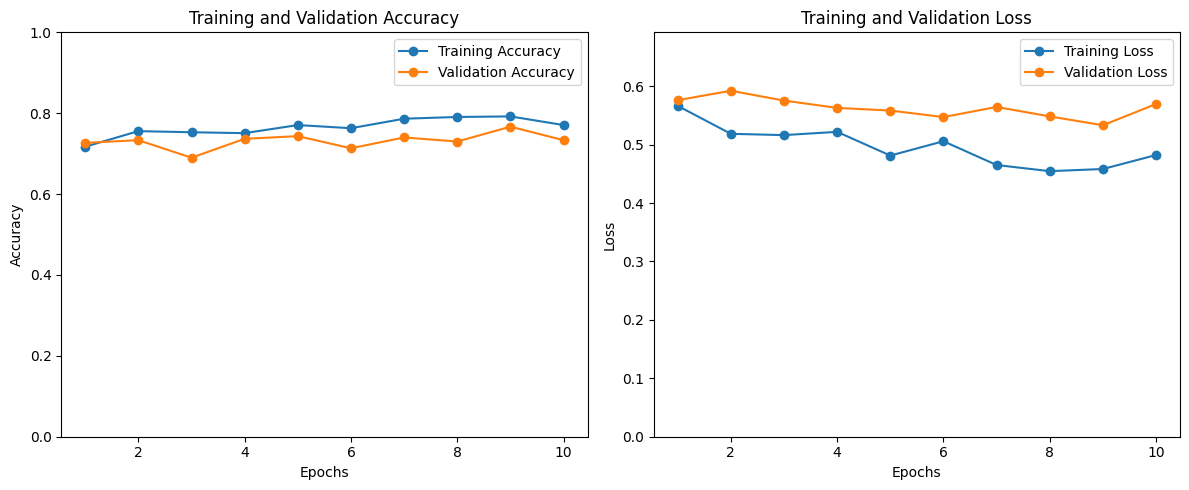

In [29]:
import matplotlib.pyplot as plt

# Extracted metrics
train_losses = [0.5663, 0.5184, 0.5162, 0.5218, 0.4812, 0.5057, 0.4650, 0.4545, 0.4582, 0.4821]
val_losses = [0.5760, 0.5921, 0.5753, 0.5628, 0.5582, 0.5471, 0.5644, 0.5482, 0.5331, 0.5694]
train_accuracies = [0.7171, 0.7557, 0.7529, 0.7507, 0.7707, 0.7629, 0.7864, 0.7907, 0.7921, 0.7707]
val_accuracies = [0.7267, 0.7333, 0.6900, 0.7367, 0.7433, 0.7133, 0.7400, 0.7300, 0.7667, 0.7333]

# Number of epochs
epochs = range(1, len(train_losses) + 1)

# Plotting the Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# Plotting the Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, max(max(train_losses), max(val_losses)) + 0.1)  # Adjust y-axis limit
plt.legend()

plt.tight_layout()
plt.show()


In [30]:
# After training your model, save the state dictionary
torch.save(model.state_dict(), r'C:\deepfake videos\models\dfd_model_weights.pth')

In [31]:
torch.save(model, r'C:\deepfake videos\models\dfd_model.pth')

In [41]:
import os

# Check if the model file exists
model_path = r'C:\deepfake videos\models\dfd_model.pth'
print(os.path.exists(model_path))  # Should print True if the file exists


True


In [17]:
# Load the entire model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(r'C:\deepfake videos\models\dfd_model.pth', map_location=device)
model.to(device)  # Move the model to the appropriate device
model.eval()  # Set the model to evaluation mode
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
# Initialize variables for test loss and accuracy
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
true_labels = []
predicted_labels = []

# No gradient calculation needed during testing
with torch.no_grad():
    for video, labels in test_dataloader:
        video = video.to(device).float()  # Ensure video is float
        labels = labels.to(device).float().view(-1, 1)  # Ensure labels are reshaped for comparison

        # Forward pass
        outputs = model(video)

        # Apply sigmoid to the outputs to get probabilities
        outputs = torch.sigmoid(outputs)

        # Calculate loss
        loss = criterion(outputs, labels)  # Compute the loss
        test_loss += loss.item()

        # Get predictions
        predicted = torch.round(outputs).view(-1)  # Assuming binary classification
        true_labels.extend(labels.view(-1).cpu().numpy())  # Collect true labels
        predicted_labels.extend(predicted.cpu().numpy()) 
        correct_predictions += (predicted == labels.view(-1)).sum().item()
        total_predictions += labels.size(0)

# Calculate average loss and accuracy
average_test_loss = test_loss / len(test_dataloader)
accuracy = correct_predictions / total_predictions

# Print results
print(f'Test Loss: {average_test_loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')


C:\Users\Atharva\AppData\Local\Temp\ipykernel_15892\1964407476.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(r'C:\deepfake videos\models\dfd_model.p

Test Loss: 0.6365
Test Accuracy: 71.00%


#Code for testing the trained model

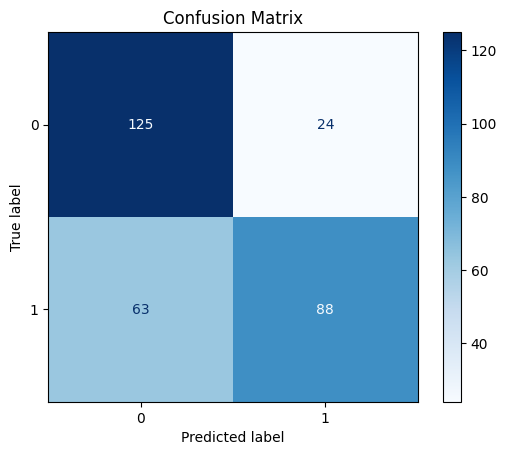

In [18]:
# Calculate the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Assuming binary classification
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()